# Лабораторная работа 1. Анализ тональности на основе BERT

### Задание 1. Получение оценок качества с классической моделью BERT
В этом задании требуется получить оценки качества на обучающих данных Kaggle (https://www.kaggle.com/c/sentiment-analysis-in-russian/data) с применением модели `RuBERT` на основе отложенной выборки или кросс-валидации.  

При выполнении задания можно воспользоваться предоставленным ноутбуком (`huggingface_bert_finetuning`).  
Подберите гиперпараметры (по крайней мере, количество эпох).  

Выведите результаты и время построения моделей в удобном табличном виде, а также в виде графиков.

In [1]:
import random
from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics
import torch
from datasets import Dataset
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support
from transformers import BertConfig, BertForSequenceClassification, BertTokenizer, Trainer, TrainingArguments

full_train_data = pd.read_json("train.json")
full_test_data = pd.read_json("test.json")

In [2]:
def one_hot_encode(data):
    data['label'] = data['sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})
    return data

def one_hot_decode(data : pd.DataFrame):
    data['sentiment'] = data['label'].map({0: 'negative', 1: 'neutral', 2: 'positive'})
    data = data.drop(columns=['label'], inplace=True)
    return data

full_train_data = one_hot_encode(full_train_data)

In [3]:
PRE_TRAINED_MODEL_NAME = 'ai-forever/ruBert-base'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

MAX_LEN = 512
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [4]:
from sklearn.model_selection import train_test_split

train_data, eval_data = train_test_split(full_train_data, test_size=0.2, random_state=seed, stratify=full_train_data['label'])

full_train_dataset = Dataset.from_pandas(full_train_data)
train_dataset = Dataset.from_pandas(train_data)
eval_dataset = Dataset.from_pandas(eval_data)
full_test_dataset = Dataset.from_pandas(full_test_data)

In [5]:
def tokenize(batch):
    return tokenizer(
        batch['text'],
        max_length=MAX_LEN,
        padding='max_length',
        truncation='longest_first'
    )

full_train_dataset = full_train_dataset.map(tokenize, batched=True, batch_size=len(full_train_dataset))
train_dataset = train_dataset.map(tokenize, batched=True, batch_size=len(train_dataset))
eval_dataset = eval_dataset.map(tokenize, batched=True, batch_size=len(eval_dataset))
full_test_dataset = full_test_dataset.map(tokenize, batched=True, batch_size=len(full_test_dataset))

Map:   0%|          | 0/8263 [00:00<?, ? examples/s]

Map:   0%|          | 0/6610 [00:00<?, ? examples/s]

Map:   0%|          | 0/1653 [00:00<?, ? examples/s]

Map:   0%|          | 0/2056 [00:00<?, ? examples/s]

In [6]:
full_train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
eval_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
full_test_dataset.set_format('torch', columns=['input_ids', 'attention_mask'])

In [7]:
full_train_dataset[0].keys()

dict_keys(['label', 'input_ids', 'attention_mask'])

In [8]:
config = BertConfig.from_pretrained(PRE_TRAINED_MODEL_NAME)
config.num_labels

2

In [9]:
config.num_labels = 3
model = BertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME, config=config)
model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruBert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(120138, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [10]:
all_parameters = 0
trainable_parameters = 0
for parameter in model.named_parameters():
    print(f'{parameter[0]}: {list(parameter[1].data.size())} - {parameter[1].numel()}')
    all_parameters += parameter[1].numel()
    if parameter[1].requires_grad:
        trainable_parameters += parameter[1].numel()

print(f'\nAll parameters = {all_parameters}')
print(f'Trainable parameters = {trainable_parameters}')

bert.embeddings.word_embeddings.weight: [120138, 768] - 92265984
bert.embeddings.position_embeddings.weight: [512, 768] - 393216
bert.embeddings.token_type_embeddings.weight: [2, 768] - 1536
bert.embeddings.LayerNorm.weight: [768] - 768
bert.embeddings.LayerNorm.bias: [768] - 768
bert.encoder.layer.0.attention.self.query.weight: [768, 768] - 589824
bert.encoder.layer.0.attention.self.query.bias: [768] - 768
bert.encoder.layer.0.attention.self.key.weight: [768, 768] - 589824
bert.encoder.layer.0.attention.self.key.bias: [768] - 768
bert.encoder.layer.0.attention.self.value.weight: [768, 768] - 589824
bert.encoder.layer.0.attention.self.value.bias: [768] - 768
bert.encoder.layer.0.attention.output.dense.weight: [768, 768] - 589824
bert.encoder.layer.0.attention.output.dense.bias: [768] - 768
bert.encoder.layer.0.attention.output.LayerNorm.weight: [768] - 768
bert.encoder.layer.0.attention.output.LayerNorm.bias: [768] - 768
bert.encoder.layer.0.intermediate.dense.weight: [3072, 768] - 235

In [11]:
hyperparameters_stats_df = pd.DataFrame(
    data=None,
    columns=['epochs', 'f1-score', 'train_time', 'eval_time'])
hyperparameters_stats_df_index = 0

def append_stats(epochs, score, train_time, eval_time):
    global hyperparameters_stats_df_index
    hyperparameters_stats_df.loc[hyperparameters_stats_df_index] = [epochs, score, train_time, eval_time]
    hyperparameters_stats_df_index += 1

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1_mean': np.mean(f1),
        'f1': f1.tolist(),
        'precision': precision.tolist(),
        'recall': recall.tolist()
    }

epochs_number = [1, 2, 3, 5]

for epoch in epochs_number:
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    
    model = BertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME, config=config)
    model.to(device)
    
    training_args = TrainingArguments(
        output_dir='./results',
        overwrite_output_dir=True,
        save_steps=5000,
        num_train_epochs=epoch,
        per_device_train_batch_size=2,
        per_device_eval_batch_size=2,
        weight_decay=0.01,
        learning_rate=1e-5,
        logging_dir='./logs',
        evaluation_strategy='epoch',
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics=compute_metrics
    )

    train_start_time = time()
    trainer.train()
    train_end_time = time()
    
    eval_start_time = time()
    eval_results = trainer.evaluate(eval_dataset)
    eval_end_time = time()
    
    print(eval_results)
    macro_f1_score = np.mean(eval_results['eval_f1'])
    append_stats(epoch, macro_f1_score, train_end_time - train_start_time, eval_end_time - eval_start_time)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruBert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\bred7\anaconda3\envs\vyatsu_environment\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\bred7\anaconda3\envs\vyatsu_environment\Lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Mean,F1,Precision,Recall
1,0.905700,0.944133,0.684815,0.682870,"[0.6735395189003437, 0.685785536159601, 0.6892857142857143]","[0.6644067796610169, 0.6900878293601004, 0.6880570409982175]","[0.6829268292682927, 0.6815365551425031, 0.6905187835420393]"


{'eval_loss': 0.9441326856613159, 'eval_accuracy': 0.6848154869933454, 'eval_f1_mean': 0.682870256448553, 'eval_f1': [0.6735395189003437, 0.685785536159601, 0.6892857142857143], 'eval_precision': [0.6644067796610169, 0.6900878293601004, 0.6880570409982175], 'eval_recall': [0.6829268292682927, 0.6815365551425031, 0.6905187835420393], 'eval_runtime': 100.437, 'eval_samples_per_second': 16.458, 'eval_steps_per_second': 8.234, 'epoch': 1.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruBert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\bred7\anaconda3\envs\vyatsu_environment\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Mean,F1,Precision,Recall
1,0.924100,0.900037,0.688445,0.686624,"[0.6890756302521008, 0.6984318455971049, 0.6723646723646723]","[0.6655844155844156, 0.6803760282021152, 0.7165991902834008]","[0.7142857142857143, 0.7174721189591078, 0.6332737030411449]"
2,0.868400,1.125993,0.701754,0.699857,"[0.6980108499095841, 0.7095990279465371, 0.6919602529358627]","[0.7255639097744361, 0.6960667461263409, 0.698905109489051]","[0.6724738675958188, 0.7236679058240396, 0.6851520572450805]"


{'eval_loss': 1.1259928941726685, 'eval_accuracy': 0.7017543859649122, 'eval_f1_mean': 0.6998567102639947, 'eval_f1': [0.6980108499095841, 0.7095990279465371, 0.6919602529358627], 'eval_precision': [0.7255639097744361, 0.6960667461263409, 0.698905109489051], 'eval_recall': [0.6724738675958188, 0.7236679058240396, 0.6851520572450805], 'eval_runtime': 100.8809, 'eval_samples_per_second': 16.386, 'eval_steps_per_second': 8.198, 'epoch': 2.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruBert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\bred7\anaconda3\envs\vyatsu_environment\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Mean,F1,Precision,Recall
1,0.926200,0.870662,0.686630,0.687102,"[0.6989966555183946, 0.6937537901758641, 0.6685552407932012]","[0.6720257234726688, 0.6793349168646081, 0.708]","[0.7282229965156795, 0.7087980173482032, 0.6332737030411449]"
2,0.894900,1.189744,0.695705,0.694982,"[0.6894075403949731, 0.6926952141057935, 0.7028423772609819]","[0.7111111111111111, 0.704225352112676, 0.6777408637873754]","[0.6689895470383276, 0.6815365551425031, 0.7298747763864043]"
3,0.668700,1.407323,0.701754,0.704196,"[0.7155025553662692, 0.7000634115409005, 0.6970227670753065]","[0.7, 0.7168831168831169, 0.6826758147512865]","[0.7317073170731707, 0.6840148698884758, 0.7119856887298748]"


{'eval_loss': 1.4073231220245361, 'eval_accuracy': 0.7017543859649122, 'eval_f1_mean': 0.7041962446608254, 'eval_f1': [0.7155025553662692, 0.7000634115409005, 0.6970227670753065], 'eval_precision': [0.7, 0.7168831168831169, 0.6826758147512865], 'eval_recall': [0.7317073170731707, 0.6840148698884758, 0.7119856887298748], 'eval_runtime': 101.2008, 'eval_samples_per_second': 16.334, 'eval_steps_per_second': 8.172, 'epoch': 3.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruBert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\bred7\anaconda3\envs\vyatsu_environment\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Mean,F1,Precision,Recall
1,0.929900,0.863426,0.689655,0.689172,"[0.6959459459459459, 0.6973923590054578, 0.6741784037558686]","[0.6754098360655738, 0.6828978622327792, 0.7094861660079052]","[0.7177700348432056, 0.7125154894671624, 0.6422182468694096]"
2,0.936300,1.229015,0.696915,0.695245,"[0.6870503597122302, 0.6966854283927455, 0.7019982623805386]","[0.7100371747211895, 0.7032828282828283, 0.6824324324324325]","[0.6655052264808362, 0.6902106567534076, 0.7227191413237924]"
3,0.666000,1.414410,0.692075,0.689914,"[0.7163695299837926, 0.713697824808936, 0.6396761133603239]","[0.6696969696969697, 0.6789709172259508, 0.7365967365967366]","[0.7700348432055749, 0.7521685254027262, 0.5652951699463328]"
4,0.588700,1.575537,0.701754,0.705490,"[0.7213675213675214, 0.6974683544303798, 0.6976336546888694]","[0.7080536912751678, 0.7128072445019404, 0.6838487972508591]","[0.735191637630662, 0.6827757125154895, 0.7119856887298748]"
5,0.430500,1.777277,0.693890,0.696146,"[0.7087719298245614, 0.6952203600248293, 0.6844444444444444]","[0.7137809187279152, 0.6965174129353234, 0.6802120141342756]","[0.7038327526132404, 0.6939281288723668, 0.6887298747763864]"


{'eval_loss': 1.7772767543792725, 'eval_accuracy': 0.6938898971566848, 'eval_f1_mean': 0.6961455780979451, 'eval_f1': [0.7087719298245614, 0.6952203600248293, 0.6844444444444444], 'eval_precision': [0.7137809187279152, 0.6965174129353234, 0.6802120141342756], 'eval_recall': [0.7038327526132404, 0.6939281288723668, 0.6887298747763864], 'eval_runtime': 100.4934, 'eval_samples_per_second': 16.449, 'eval_steps_per_second': 8.229, 'epoch': 5.0}


In [13]:
hyperparameters_stats_df.to_csv('hyperparameters_stats.csv')
hyperparameters_stats_df

,epochs,f1-score,train_time,eval_time
0,1.0,0.682870,1710.766051,100.440995
1,2.0,0.699857,3419.633710,100.884864
2,3.0,0.704196,5136.203120,101.204846
3,5.0,0.696146,8561.273212,100.497365


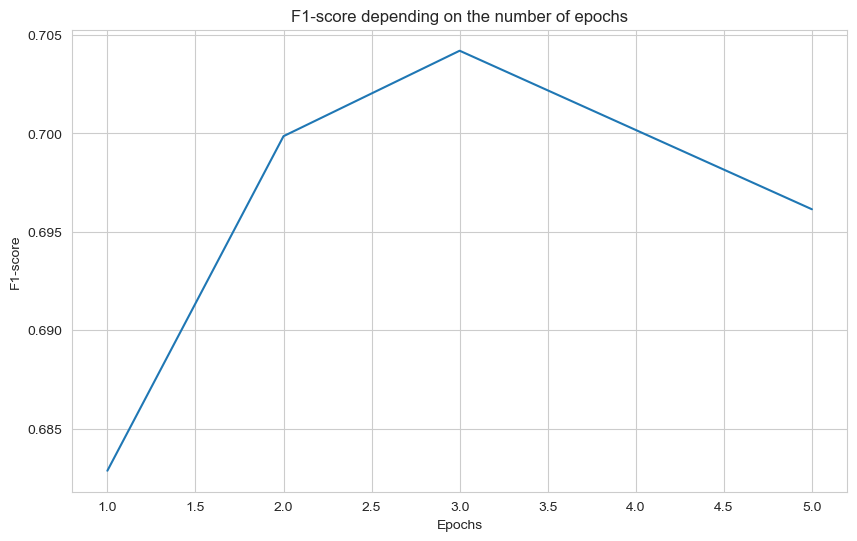

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(hyperparameters_stats_df['epochs'], hyperparameters_stats_df['f1-score'])
plt.xlabel('Epochs')
plt.ylabel('F1-score')
plt.title('F1-score depending on the number of epochs')
plt.show()

In [17]:
epochs_number = 1

np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

model = BertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME, config=config)
model.to(device)

training_args = TrainingArguments(
    output_dir='./results',
    overwrite_output_dir=True,
    save_steps=5000,
    num_train_epochs=epochs_number,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    weight_decay=0.01,
    learning_rate=1e-5,
    logging_dir='./logs',
    evaluation_strategy='epoch',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=full_train_dataset,
    eval_dataset=full_test_dataset,
    compute_metrics=compute_metrics
)

train_start_time = time()
trainer.train()
train_end_time = time()

eval_start_time = time()
eval_results = trainer.evaluate(eval_dataset)
eval_end_time = time()

print(eval_results)
macro_f1_score = np.mean(eval_results['eval_f1'])
append_stats(epochs_number, macro_f1_score, train_end_time - train_start_time, eval_end_time - eval_start_time)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruBert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\bred7\anaconda3\envs\vyatsu_environment\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,1.042300,No log


{'eval_loss': 0.820832371711731, 'eval_accuracy': 0.7332123411978222, 'eval_f1_mean': 0.7328821693515023, 'eval_f1': [0.7358834244080146, 0.738255033557047, 0.7245080500894454], 'eval_precision': [0.7709923664122137, 0.7271634615384616, 0.7245080500894454], 'eval_recall': [0.7038327526132404, 0.7496902106567535, 0.7245080500894454], 'eval_runtime': 100.6889, 'eval_samples_per_second': 16.417, 'eval_steps_per_second': 8.213, 'epoch': 1.0}


In [18]:
torch.save(model, "bert_trained_1e.pt")

### Задание 2. Использование BERT как модель для формирования векторных представлений текстов
Основная функция BERT-подобных моделей – формирование контекстно-ориентированных векторных представлений текстов.  
В данном задании нужно будет сделать следующее:
1) обучить RuBERT (как в предыдущем задании);
1) получить из него векторные представления обучающих текстов (например, вектор токена `[CLS]` или среднее векторов всех токенов на последнем слое (см. варианты [здесь](https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/#35-pooling-strategy--layer-choice));
1) применить традиционные модели машинного обучения (логистическая регрессия, SVM, градиентный бустинг и т.п.). Не забывайте про подбор гиперапараметров;
1) получить оценки качества – на таком же разбиении, как в предыдущем задании.

Выведите результаты и время построения моделей в удобном табличном виде, а также в виде графиков.

In [50]:
cut_model = model.bert

def vectorize(text):
    inputs = tokenizer(
        text,
        return_tensors='pt',
        max_length=MAX_LEN,
        padding='max_length',
        truncation='longest_first'
    )
    inputs.to(device)
    
    with torch.no_grad():
        outputs = cut_model(**inputs)
    
    cut_model_output = outputs.last_hidden_state
    mean_output = torch.mean(cut_model_output, dim=1)
    return mean_output.cpu().numpy()[0]

full_train_dataset_vectorized = full_train_dataset.map(lambda x: {'vector': vectorize(x['text'])})
full_test_dataset_vectorized = full_test_dataset.map(lambda x: {'vector': vectorize(x['text'])})

Map:   0%|          | 0/8263 [00:00<?, ? examples/s]

Map:   0%|          | 0/2056 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'id', 'sentiment', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 8263
})

In [56]:
train_dataset_vectorized = train_dataset.map(lambda x: {'vector': vectorize(x['text'])})
eval_dataset_vectorized = eval_dataset.map(lambda x: {'vector': vectorize(x['text'])})

Map:   0%|          | 0/6610 [00:00<?, ? examples/s]

Map:   0%|          | 0/1653 [00:00<?, ? examples/s]

In [57]:
train_x = np.array([x['vector'] for x in train_dataset_vectorized])
train_y = np.array([x['label'] for x in train_dataset_vectorized])
eval_x = np.array([x['vector'] for x in eval_dataset_vectorized])
eval_y = np.array([x['label'] for x in eval_dataset_vectorized])

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

hyperparameters_stats_df = pd.DataFrame(
    data=None,
    columns=['model', 'hyperparameters', 'f1-score', 'train_time', 'eval_time'])
hyperparameters_stats_df_index = 0

def append_stats(model_name, hyperparameters, score, train_time, eval_time):
    global hyperparameters_stats_df_index
    hyperparameters_stats_df.loc[hyperparameters_stats_df_index] = [model_name, hyperparameters, score, train_time, eval_time]
    hyperparameters_stats_df_index += 1
  

for C in [0.1, 1, 10]:
    model = LogisticRegression(max_iter=1000, C=C)
    
    train_start_time = time()
    model.fit(train_x, train_y)
    train_end_time = time()
    
    eval_start_time = time()
    eval_predictions = model.predict(eval_x)
    eval_end_time = time()
    
    f1_score = precision_recall_fscore_support(eval_y, eval_predictions, average='macro')[2]
    append_stats('Logistic Regression', {'C': C}, f1_score, train_end_time - train_start_time, eval_end_time - eval_start_time)
    
for C in [0.1, 1, 10]:
    model = SVC(C=C)
    
    train_start_time = time()
    model.fit(train_x, train_y)
    train_end_time = time()
    
    eval_start_time = time()
    eval_predictions = model.predict(eval_x)
    eval_end_time = time()
    
    f1_score = precision_recall_fscore_support(eval_y, eval_predictions, average='macro')[2]
    append_stats('SVM', {'C': C}, f1_score, train_end_time - train_start_time, eval_end_time - eval_start_time)
    
for n_estimators in [10, 50, 100]:
    model = GradientBoostingClassifier(n_estimators=n_estimators)
    
    train_start_time = time()
    model.fit(train_x, train_y)
    train_end_time = time()
    
    eval_start_time = time()
    eval_predictions = model.predict(eval_x)
    eval_end_time = time()
    
    f1_score = precision_recall_fscore_support(eval_y, eval_predictions, average='macro')[2]
    append_stats('Gradient Boosting', {'n_estimators': n_estimators}, f1_score, train_end_time - train_start_time, eval_end_time - eval_start_time)

In [59]:
hyperparameters_stats_df.to_csv('hyperparameters_stats_vectorized.csv')
hyperparameters_stats_df

,model,hyperparameters,f1-score,train_time,eval_time
0,Logistic Regression,{'C': 0.1},0.739225,2.025602,0.005996
1,Logistic Regression,{'C': 1},0.727618,4.417614,0.005990
2,Logistic Regression,{'C': 10},0.715839,8.065708,0.005995
3,SVM,{'C': 0.1},0.717682,14.978484,4.595023
4,SVM,{'C': 1},0.735268,15.182518,4.826404
5,SVM,{'C': 10},0.749941,13.979378,4.644447
6,Gradient Boosting,{'n_estimators': 10},0.721282,68.904488,0.006004
7,Gradient Boosting,{'n_estimators': 50},0.725982,348.808835,0.024918
8,Gradient Boosting,{'n_estimators': 100},0.724478,699.887645,0.018979


### Задание 3. Оценка качества классификации на Kaggle
Выберите лучшую модель, обучите её на всем обучающем корпусе, получите предсказания для тестовых данных и отправьте результаты на Kaggle.  

Сравните полученные результаты с результатами на Kaggle: https://www.kaggle.com/c/sentiment-analysis-in-russian/leaderboard.

Выведите кроме `macro F1-score` следующие метрики для отложенной выборки:
- `F1-score` по каждому классу;
- `Precision` и `Recall` по каждому классу;
- `Confusion matrix` по каждому классу и для всей выборки.

Сделайте выводы в целом по своим исследованиям – приведите в одной таблице несколько лучших моделей с указанием параметров и времени работы.

In [88]:
model = SVC(C=10)
model.fit(train_x, train_y)
test_predictions = model.predict(eval_x)

print(sklearn.metrics.classification_report(eval_y, test_predictions, target_names=['negative', 'neutral', 'positive']))

              precision    recall  f1-score   support

    negative       0.77      0.77      0.77       287
     neutral       0.75      0.75      0.75       807
    positive       0.73      0.73      0.73       559

    accuracy                           0.75      1653
   macro avg       0.75      0.75      0.75      1653
weighted avg       0.75      0.75      0.75      1653



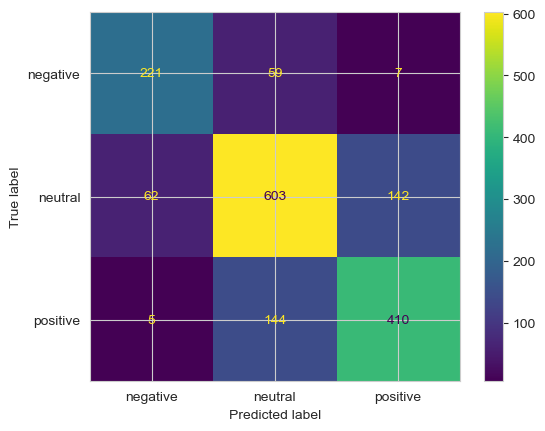

In [101]:
sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix(eval_y, test_predictions), display_labels=['negative', 'neutral', 'positive']).plot()

In [103]:
all_train_x = np.array([x['vector'] for x in full_train_dataset_vectorized])
all_train_y = np.array([x['label'] for x in full_train_dataset])
test_x = np.array([x['vector'] for x in full_test_dataset_vectorized])

In [104]:
model = SVC(C=10)
model.fit(all_train_x, all_train_y)
test_predictions = model.predict(test_x)

In [107]:
test_predictions

array([2, 2, 0, ..., 2, 1, 0], dtype=int64)

In [112]:
full_test_data['sentiment'] = test_predictions
full_test_data['sentiment'] = full_test_data['sentiment'].map({0: 'negative', 1: 'neutral', 2: 'positive'})

In [113]:
with open('submission.csv', 'w') as f:
    f.write(full_test_data[['id', 'sentiment']].to_csv(index=False))